In [1]:
import numpy as np
import pandas as pd
import os, glob, shutil
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from tqdm import tqdm

import torch
from torch import Tensor
from torch.autograd import Function
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset , DataLoader
from torchvision import transforms , utils , datasets

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Editable Part

**==============================================**

Edit only this part. Specify the following: 


*   the folder name `DRIVE_FOLDER_NAME` which contains original data and where the preprocessed data will be kept;
*   `IMGS_FOLDER_NAME` and `MASKS_FOLDER_NAME` which are the names of the folders with images and their masks accordingly.

In [3]:
DATASET_FOLDER_NAME = '/content/drive/MyDrive/INF573/cats_dataset/'
IMGS_FOLDER_NAME = 'cats_images/'
MASKS_FOLDER_NAME = 'cats_masks/'
COMBINED_IMGS_FOLDER_NAME = 'image_sketch/'

**==============================================**

### Data Preprocessing Helpers

In [ ]:
def transform(img, mask, size: tuple, crop_size: tuple):
    """
    returns resized and center cropped image and its mask
    arguments:
        -img: original image
        -mask: mask corresponding to the original image,
        -size: size of image after applying resize
        -crop_size: size of image after applying center crop
    """
    
    img_resized = cv2.resize(img, size)
    mask_resized = cv2.resize(mask, size)
    w, h = crop_size
    center = img_resized.shape [0] / 2, img_resized.shape [1] / 2
    x = center[1] - w/2
    y = center[0] - h/2
    crop_img = img_resized[int(y):int(y+h), int(x):int(x+w)]
    crop_mask = mask_resized[int(y):int(y+h), int(x):int(x+w)]
    return crop_img, crop_mask 

def mask_preprocessing(mask):
    
    _, mask = cv2.threshold(mask, mask.min(), 255, cv2.THRESH_BINARY_INV)
    return mask 

def save_img_and_sketch(img_name: str, 
                       index: int, 
                       size: tuple,
                       crop_size: tuple,
                       canny_threshold_1: int,
                       canny_threshold_2: int,
                       mask_preprocessing=False):
    """
    This function gets an image, applies transorms to it,
    computes skecth from the given image,
    combines image and sketch and saves them as one image to the folder
    arguments:
        -img_path: name of the image,
        -dataset_path: path to store the dataset,
        -index: index of the given image, used to rename images by their indexes,
        -size: size of image after applying resize
        -crop_size: size of image after applying center crop
        -canny_threshold_1: threshold_1 used in canny edge detection implementation of opencv,
        -canny_threshold_2: threshold_2 used in canny edge detection implementation of opencv
    """
    img = cv2.imread(DATASET_FOLDER_NAME+IMGS_FOLDER_NAME+img_name)
    mask_name = img_name.split('.')[0] + '.' + FORMAT
    mask = np.array(Image.open(DATASET_FOLDER_NAME+MASKS_FOLDER_NAME+mask_name))
    if mask_preprocessing:
        mask = mask_preprocessing(mask)
    img, mask = transform(img, mask, size=size, crop_size=crop_size)
    img[mask == 0] = 255
    sketch = 255 - cv2.Canny(img, canny_threshold_1, canny_threshold_2)
    sketch = np.stack((sketch,)*3, axis=-1)   # make BW image have 3 color channels
    img_combined = np.concatenate([img, sketch], 1)
    os.chdir(DATASET_FOLDER_NAME)
    try:
        os.makedirs(COMBINED_IMGS_FOLDER_NAME)
    except FileExistsError:
        pass
    cv2.imwrite(COMBINED_IMGS_FOLDER_NAME+str(index)+'.jpg', img_combined)

def split_dataset(train_size: float, dataset_dir: str=COMBINED_IMGS_FOLDER_NAME):
    """
    splits data to train and test and moves them to the corresponding directories
    arguments:
        - dataset_dir: directory in which the dataset is stored,
        - train_size: from 0 to 1
    """
    os.chdir(DATASET_FOLDER_NAME+dataset_dir)
    list_img = glob.glob('*.jpg')
    
    number_of_train_imgs = int(len(list_img) * train_size)
    train_imgs = sorted(list_img)[:number_of_train_imgs]
    test_imgs = sorted(list_img)[number_of_train_imgs:]
    
    for img in tqdm(train_imgs):
        try:
            os.makedirs('train/')
        except FileExistsError:
            pass
        shutil.move(img, 'train/'+img)
        
    for img in tqdm(test_imgs):
        try:
            os.makedirs('test/')
        except FileExistsError:
            pass
        shutil.move(img, 'test/'+img)

#Pipeline

1. Load image and its corresponding mask
2. Transform them
3. Delete background
4. Create a sketch
5. Combine sketch and image
6. Split it to train and test
7. Train the model
8. Load the trained model and test it

In [ ]:
os.chdir(DATASET_FOLDER_NAME + IMGS_FOLDER_NAME)
list_of_images = glob.glob('*.jpg')
os.chdir(DATASET_FOLDER_NAME + MASKS_FOLDER_NAME)
list_of_masks = glob.glob('*')
FORMAT = list_of_masks[0].split('.')[1]
for i, img_name in tqdm(enumerate(list_of_images[:6672])):
    save_img_and_sketch(img_name=img_name, 
                   index=i, 
                   size=(400, 350),
                   crop_size=(256,256),
                   canny_threshold_1=110,
                   canny_threshold_2=150,
                   mask_preprocessing=mask_preprocessing)
    
split_dataset(train_size=0.8)

6672it [03:22, 33.00it/s]
100%|██████████| 1335/1335 [00:05<00:00, 242.93it/s]


### Model training

In [6]:
os.chdir('/content/')
!git clone https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix
os.chdir('pytorch-CycleGAN-and-pix2pix/')
!pip install -r requirements.txt
!bash ./scripts/download_pix2pix_model.sh edges2shoes

Cloning into 'pytorch-CycleGAN-and-pix2pix'...
remote: Enumerating objects: 2443, done.
remote: Total 2443 (delta 0), reused 0 (delta 0), pack-reused 2443
Receiving objects: 100% (2443/2443), 8.13 MiB | 22.45 MiB/s, done.
Resolving deltas: 100% (1570/1570), done.
     |████████████████████████████████| 676 kB 6.3 MB/s 
     |████████████████████████████████| 1.7 MB 37.4 MB/s 
     |████████████████████████████████| 53 kB 2.0 MB/s 
     |████████████████████████████████| 180 kB 47.1 MB/s 
     |████████████████████████████████| 97 kB 6.8 MB/s 
     |████████████████████████████████| 140 kB 49.0 MB/s 
     |████████████████████████████████| 63 kB 1.9 MB/s 
  Created wheel for visdom: filename=visdom-0.1.8.9-py3-none-any.whl size=655250 sha256=dc3d1a1d20cbbf8844c6b38f9fd1665e47ac193c0cda603f521cc02459600b87
  Stored in directory: /root/.cache/pip/wheels/2d/d1/9b/cde923274eac9cbb6ff0d8c7c72fe30a3da9095a38fd50bbf1
  Created wheel for subprocess32: filename=subprocess32-3.5.4-py3-none-any.wh

In [9]:
dataset_dir = DATASET_FOLDER_NAME+COMBINED_IMGS_FOLDER_NAME
model_dir = DATASET_FOLDER_NAME+'edges2cats'

In [ ]:
!python train.py --dataroot '$dataset_dir' --name edges2cats --model pix2pix --gpu_ids 0 --direction BtoA --checkpoints_dir '$DATASET_FOLDER_NAME' --continue_train --epoch_count 12

----------------- Options ---------------
               batch_size: 1                             
                    beta1: 0.5                           
          checkpoints_dir: /content/drive/MyDrive/INF573/cats_dataset/	[default: ./checkpoints]
           continue_train: True                          	[default: False]
                crop_size: 256                           
                 dataroot: /content/drive/MyDrive/INF573/cats_dataset/image_sketch/	[default: None]
             dataset_mode: aligned                       
                direction: BtoA                          	[default: AtoB]
              display_env: main                          
             display_freq: 400                           
               display_id: 1                             
            display_ncols: 4                             
             display_port: 8097                          
           display_server: http://localhost              
          display_winsize: 256   

In [10]:
!python test.py --dataroot '$dataset_dir' --model pix2pix --name '$model_dir' --gpu_ids 0 --direction BtoA

----------------- Options ---------------
             aspect_ratio: 1.0                           
               batch_size: 1                             
          checkpoints_dir: ./checkpoints                 
                crop_size: 256                           
                 dataroot: /content/drive/MyDrive/INF573/cats_dataset/image_sketch/	[default: None]
             dataset_mode: aligned                       
                direction: BtoA                          	[default: AtoB]
          display_winsize: 256                           
                    epoch: latest                        
                     eval: False                         
                  gpu_ids: 0                             
                init_gain: 0.02                          
                init_type: normal                        
                 input_nc: 3                             
                  isTrain: False                         	[default: None]
              

### Results Exploration

In [15]:
test_images_dir = model_dir + '/test_latest/images/'
os.chdir(test_images_dir)
list_of_test_images = glob.glob('*fake*.png')

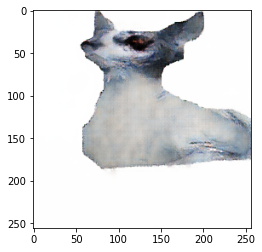

In [23]:
plt.imshow(cv2.imread(list_of_test_images[5]))

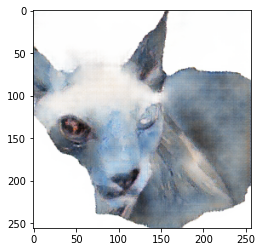

In [28]:
plt.imshow(cv2.imread(list_of_test_images[7]))

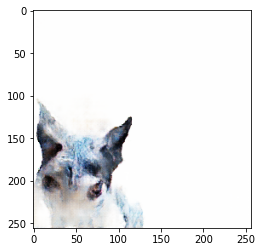

In [32]:
plt.imshow(cv2.imread(list_of_test_images[8]))